# AIDS dataset: Survival curves and protection metrics

On this notebook, we present the R code to display the figure XXXXXX of the article [lien_papier]. 

The methodology was inspired by the following article:

Scott, M. (1996). A Trial Comparing Nucleoside Monotherapy with Combination Therapy in HIV-Infected Adults with CD4 Cell Counts from 200 to 500 per Cubic Millimeter. *The NEW ENGLAND JOURNAL of MEDICINE*, 335(15), p. 1081-1090. doi: 10.1056/NEJM199610103351501

We used the avatarized dataset with the parameter k= 20. 

We performed 3 analyses: 
- 1 - An FAMD (Factor Analysis for Mixed Data) projection of an Avatar on the two first components of FAMD built on the Original dataset to observe the structural similarities. 
- 2 - Survival curves comparison between Avatar and Original datasets.
- 3 - Protection level computation (local cloaking and hidden rate).

## Libraries import

In [1]:
# Main libraries
library(tidyverse)
library(mice)
library(reshape2)

# Library to use Python with R
library(reticulate)

# Multidimensionnal reduction method libary
library(FactoMineR)

# Survival analysis libraries
library(survival)
library(survminer)

# Library  to display a corrplot
library(corrplot)
# Save corplot as svg
library(svglite)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: ggpubr

corrplot 0.91 loaded



In [4]:
colors <- read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) <- colors$type


The following cell import the necessary function in order to compute the metrics over the avatarization.

In [5]:
# import specific function to compute metrics
py_run_string("import sys")
py_run_string("sys.path.append('../..')")

py_run_string("from lsg.security_metrics.security_metrics_class import Security_metrics ")
py_run_string("from lsg.dimension.projection import Projection")
py_run_string("from lsg.security_metrics.record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from lsg.security_metrics.local_cloaking import local_cloaking")

## Data loading

In [6]:
file_data <- "datasets/"
data <- read.csv(paste0("../../datasets/AIDS/aids_original_data.csv"), sep = ";", na.strings = c("NA", "", NA))
data <- data[, -1]

# Avatar data with k=20
avatar <- read.csv(paste0("../../datasets/AIDS/aids_avatarized_base_k20_nf5.csv"), sep = ",", na.strings = c("NA", "", NA))

avatar$arms <- as.factor(avatar$arms)

## Data and avatar imputation - Perform projection

In [7]:
# imput missing data to project the individuals in the multidimensionnal space
data_imp <- complete(mice(data, m = 1, maxit = 50, seed = 500, printFlag = FALSE), 1)
avatar_imp <- complete(mice(avatar, m = 1, maxit = 50, seed = 500, printFlag = FALSE), 1)

Warning message:
“Number of logged events: 51”
Warning message:
“Number of logged events: 51”


In [8]:
data$cd496 <- data_imp$cd496
avatar$cd496 <- avatar_imp$cd496

In [9]:
data_tot <- rbind(data, avatar)
data_tot_num <- data_tot
categorical <- c("hemo", "homo", "drugs", "karnof", "oprior", "z30", "zprior", "race", 
                 "gender", "str2", "strat", "symptom", "treat", "offtrt", "r", "cens", "arms")
data_tot[categorical] <- lapply(data_tot[categorical], factor)

## Projection comparison


We are here printing the mutlidimensionnal projection on the two first components of the FAMD (Factorial analysis of mixed data).

Individuals are colored by data sources : ORIGINAL in white or AVATARS in green.

### Projection 

In [10]:
pca <- FAMD(data_tot, ncp = 5, graph = FALSE, ind.sup = (nrow(data_tot)/2 + 1):nrow(data_tot))
res_ind <- as.data.frame(pca$ind$coord)
res_ind_sup <- as.data.frame(pca$ind.sup$coord)

In [11]:
res_ind_2D <- res_ind[, 1:2]
res_ind_2D["type"] <- "Original"
res_ind_sup["type"] <- "Avatar"
res_ind_2D <- rbind(res_ind_2D, res_ind_sup[, c("Dim.1", "Dim.2", "type")])

set.seed(42)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows,]

### Visualization 

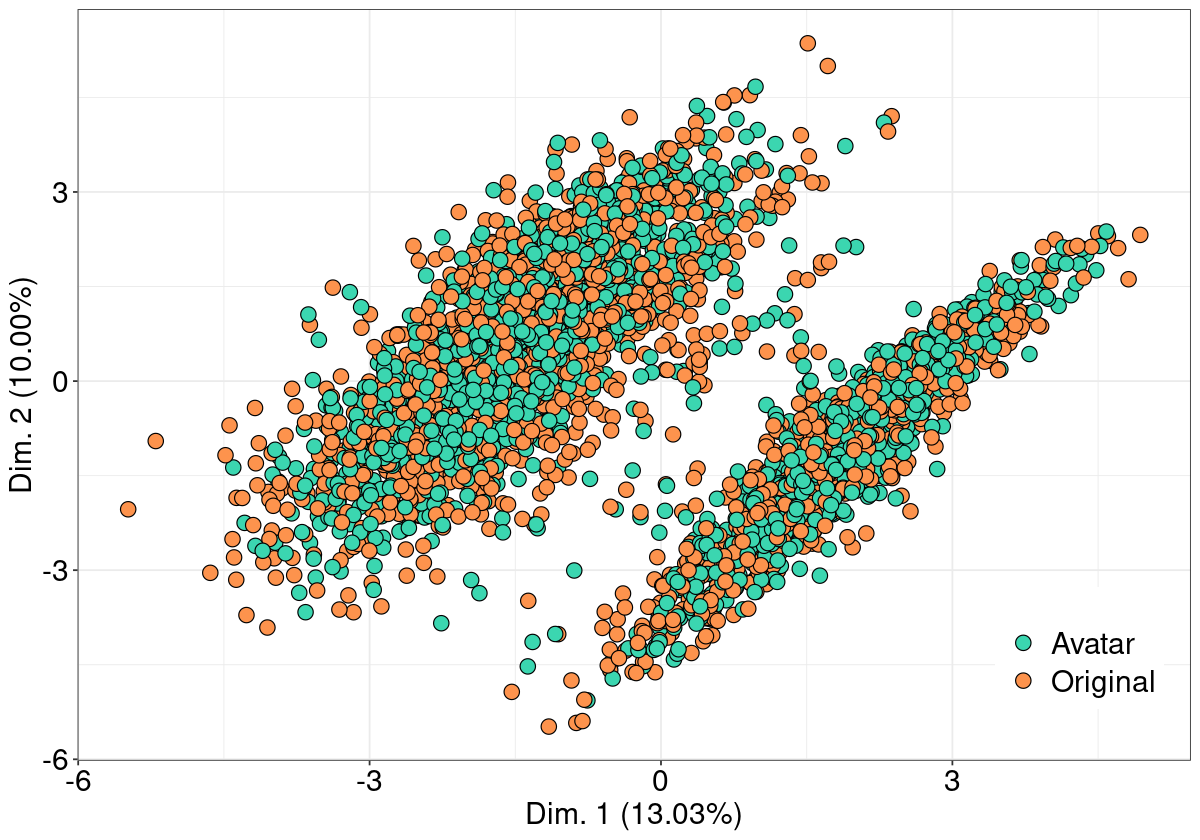

In [12]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot = ggplot(res_ind_2D, aes(x = Dim.1, y = Dim.2, fill = factor(type))) + 
    # point
    geom_point(size = 4, shape = 21, alpha = 1) + 
    # fill by type 
    aes(fill = factor(type)) + 
    scale_fill_manual(values = c(colors["avatar", "color"], colors["original", "color"])) +
    # theme and details
    xlab(paste0("Dim. 1 (", formatC(pca$eig[1, 2], format = "f", digits = 2), "%)")) +
    ylab(paste0("Dim. 2 (", formatC(pca$eig[2, 2], format = "f", digits = 2), "%)"))+ 
    labs(fill = "") +
    theme_bw() +
    theme(legend.position = c(0.9, 0.15), 
          legend.text = element_text(size = 18, color = "black",family = "sans"), 
          legend.key.size = unit(0.8, "cm"),
          axis.text = element_text(size = 18, color = "black", family = "sans"), 
          axis.title = element_text(size = 18, color = "black", family = "sans"), 
          legend.background = element_rect(fill = "white", linetype = "solid"))
plot 
 
ggsave(file="../../figure/aids_pca2D.svg", plot=plot, width=10, height=7, dpi = 320)

## Figure survival curve analysis 

We compared treatments' efficacy betwween arms 0 and arms 1 for Original and Avatar datasets.

### Original data analysis

In [13]:
data$arms <- as.factor(data$arms)
summary_cox <- summary(coxph(Surv(time = days/7, event = cens) ~ arms, data = data))
res_ori <- cbind(summary_cox$coefficients[, c("exp(coef)", "Pr(>|z|)")], summary_cox$conf.int[, c("lower .95", "upper .95")])

#### Arms 0 vs 1

In [14]:
data_arms01 <- data[data$arms %in% c(0, 1),]
data_arms01$arms <- as.factor(as.character(data_arms01$arms))
summary_cox <- summary(coxph(Surv(time = days/7, event = cens) ~ arms, data = data_arms01))
res_original_01 <- cbind(summary_cox$coefficients, summary_cox$conf.int)

### Avatar data analysis

In [15]:
summary_cox <- summary(coxph(Surv(time = days/7, event = cens) ~ arms, data = avatar))
res_avat <- cbind(summary_cox$coefficients[, c("exp(coef)", "Pr(>|z|)")], summary_cox$conf.int[, c("lower .95", "upper .95")])

#### Arms 0 vs 1

In [16]:
avatar_arms01 <- avatar[avatar$arms %in% c(0, 1),]
avatar_arms01$arms <- as.factor(as.character(avatar_arms01$arms))
summary_cox <- summary(coxph(Surv(time = days/7, event = cens) ~ arms, data = avatar_arms01))
res_avatar_01 <- cbind(summary_cox$coefficients, summary_cox$conf.int)

### Original vs Avatar

In [17]:
data_arms01$type <- "Original"
avatar_arms01$type <- "Avatar"
data_concat_01 <- rbind(data_arms01, avatar_arms01)
data_concat_01$type <- factor(data_concat_01$type, levels = c("Original", "Avatar"))

# Survival curve calculation
surv <- survfit(Surv(time = days/7, event = cens) ~ factor(arms) + type, data = data_concat_01)

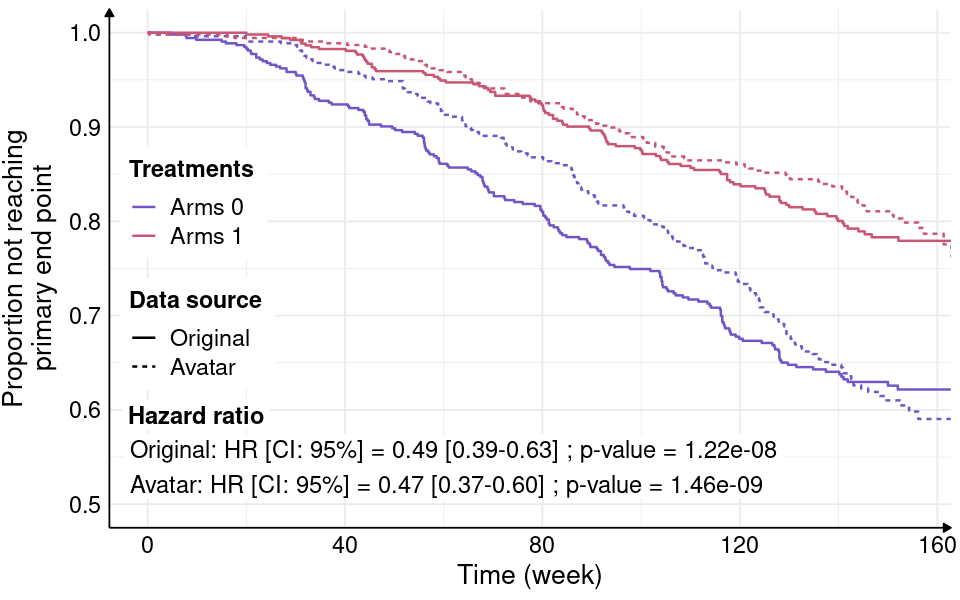

In [21]:
# Display time: about 15 seconds
color <- c("#7155c8", "#c85573")

options(repr.plot.width = 8, repr.plot.height = 5)
ggsurv <- ggsurvplot(surv, data = data_concat_01, conf.int = FALSE, 
                     risk.table = FALSE, 
                     legend.title = "Treatments",
                     censor.cex = 100, 
                     linetype = c("type"), 
                     size = 0.7, xlim = c(0, 155), ylim = c(0.5, 1), break.x.by = 40, 
                     ggtheme = theme_minimal(), 
                     xlab = "Time (week)", 
                     ylab = "Proportion not reaching\nprimary end point",
                     censor.shape = "", 
                     legend.labs = c("Arms 0", "Arms 0", "Arms 1", "Arms 1"), 
                     palette = color)

plot = ggsurv$plot <- ggsurv$plot +
    theme_minimal() +
    scale_linetype_discrete(name = c("Data source"), labels = c("Original", "Avatar")) +
    geom_label(aes(x = 9.7, y = 0.595, label = "Hazard ratio"), size = 5, family = "sans", fontface = "bold", label.size = NA) +
    geom_label(aes(x = 62, y = 0.54, label = paste0("Original: HR [CI: 95%] = ", formatC(res_original_01[2], format = "f", digits = 2),
                                                     " [", formatC(res_original_01[8], format = "f", digits = 2),
                                                     "-", formatC(res_original_01[9], format = "f", digits = 2),
                                                     "] ; p-value = ", formatC(res_original_01[5], format = "e", digits = 2), 
                                                     "\nAvatar: HR [CI: 95%] = ", formatC(res_avatar_01[2], format = "f", digits = 2),
                                                     " [", formatC(res_avatar_01[8], format = "f", digits = 2),
                                                     "-", formatC(res_avatar_01[9], format = "f", digits = 2),
                                                     "] ; p-value = ", formatC(res_avatar_01[5], format = "e", digits = 2), "  ")), size = 5, family = "sans", label.size = NA) +
    theme(legend.position = c(0.105, 0.5), 
          legend.background = element_rect(fill = "white", size = 0.5, linetype = "blank"), 
          legend.text = element_text(size = 14,  color = "black", family = "sans"), 
          legend.title = element_text(size = 14,  color = "black", family = "sans", face = "bold"),
          axis.text = element_text(size = 14, color = "black", family = "sans"), 
          axis.title.y = element_text(vjust = 2), 
          axis.title = element_text(size = 16, color = "black", family = "sans"), 
          axis.line = element_line(colour = "black", size = 0.5, linetype = "solid", arrow = arrow(type = "closed", length = unit(5, "pt"))))

plot

ggsave(file="../../figure/aids_avatar_survival.tiff", plot=plot, width=8, height=5, dpi = 320)


### Supplemental graph

As a supplemental graph we presented the survival curves for all treatments.

In [23]:
data$type <- "Original"
avatar$type <- "Avatar"
data_concat <- rbind(data, avatar)
data_concat$type <- factor(data_concat$type, levels = c("Original", "Avatar"))

# Survival curve calculation
surv <- survfit(Surv(time = days/7, event = cens) ~ factor(arms) + type, data = data_concat)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


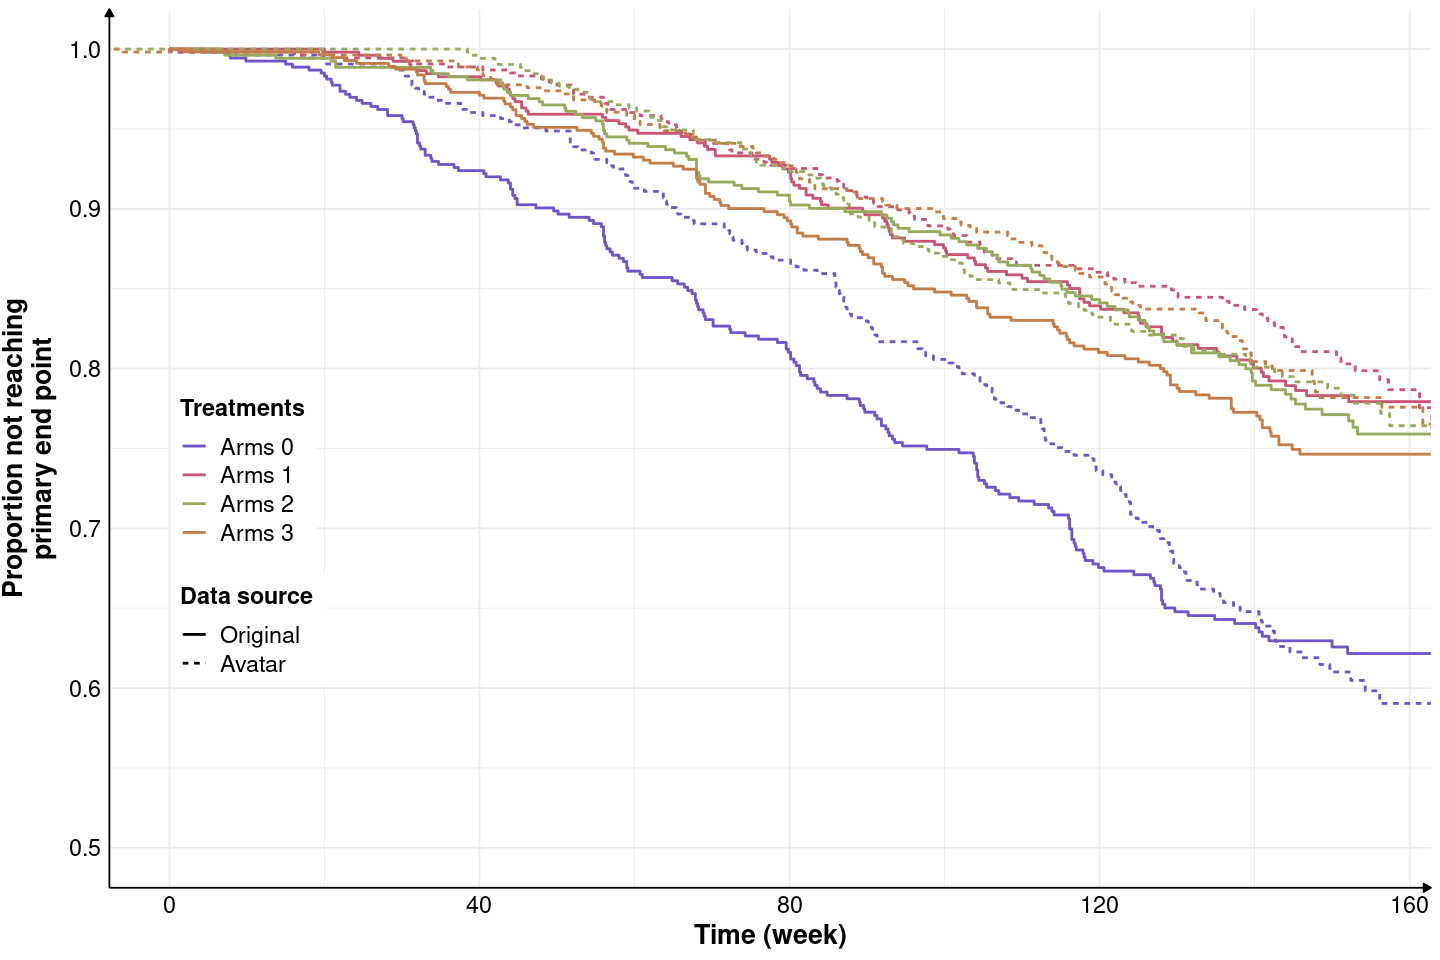

In [24]:
color <- c("#7155c8", "#c85573", "#95aa5b", "#c37e47")

options(repr.plot.width = 12, repr.plot.height = 8)
ggsurv = ggsurvplot(surv, 
                    data = data_concat, 
                    conf.int = FALSE, 
                    risk.table = FALSE, 
                    legend.title = "Treatments", 
                    legend = c(0.2, 0.3), 
                    censor.cex = 100, 
                    linetype = c("type"), 
                    size = 0.8, 
                    xlim = c(0, 155), 
                    ylim = c(0.5, 1),
                    break.x.by = 40, 
                    ggtheme = theme_minimal(), 
                    xlab = "Time (week)", 
                    ylab = "Proportion not reaching\nprimary end point", 
                    censor.shape = "", 
                    legend.labs = c("Arms 0", "Arms 0", "Arms 1", "Arms 1", "Arms 2", "Arms 2", "Arms 3", "Arms 3"), 
                    palette = color)

ggsurv$plot <- ggsurv$plot + 
    theme_minimal() + 
    theme(legend.position = c(0.105, 0.4), 
          legend.background = element_rect(fill = "white", size = 0.5, linetype = "blank"),
          legend.text = element_text(size = 14, color = "black", family = "sans"), 
          axis.text = element_text(size = 14, color = "black",  family = "sans"), 
          axis.title = element_text(size = 16, color = "black", family = "sans", face = "bold"), 
          axis.title.y = element_text(vjust = 2), 
          legend.title = element_text(size = 14, face = "bold", family = "sans"), 
          axis.line = element_line(colour = "black", size = 0.5, linetype = "solid", arrow = arrow(type = "closed", length = unit(5, "pt")))) + 
    scale_linetype_discrete(name = "Data source")

ggsurv

### Supplemental : Hazard ratio comparison 

Hazard ratio are computed: this table presentes hazard ratio with arms 0 as reference. P-value and 95% confidence intervals are shown.

In [25]:
rownames(res_ori) <- c("arms1_original", "arms2_original", "arms3_original")
rownames(res_avat) <- c("arms1_avatar", "arms2_avatar", "arms3_avatar")
res_concat <- as.data.frame(rbind(res_ori, res_avat))
res_concat["Hazard Ratio"] <- formatC(res_concat[, 1], format = "f", digits = 2)
res_concat["95% Confidence Interval"] <- paste0(formatC(res_concat[,3], format = "f", digits = 2), "-", formatC(res_concat[, 4], format = "f", digits = 2))
res_concat["p-value"] <- formatC(res_concat[,2], format = "e", digits = 2)
res_concat <- res_concat[c(1, 4, 2, 5, 3, 6), 5:7]
row.names(res_concat) <- c("Original arm 1", "Avatar arm 1", "Original arm 2", "Avatar arm 2", "Original arm 3", "Avatar arm 3")
res_concat

#write.csv(res_concat,"../../datasets/results_df/supplemental_table_aids.csv", row.names = TRUE)

,Hazard Ratio,95% Confidence Interval,p-value
,<chr>,<chr>,<chr>
Original arm 1,0.49,0.39-0.63,9.19e-09
Avatar arm 1,0.47,0.37-0.60,1.94e-09
Original arm 2,0.52,0.41-0.67,1.07e-07
Avatar arm 2,0.51,0.40-0.65,6.43e-08
Original arm 3,0.59,0.47-0.73,3.68e-06
Avatar arm 3,0.49,0.38-0.62,9.58e-09


## Protection level: metrics   

This section provides the computation of protection metrics (local cloaking and hidden rate).

We first compute metrics, which need the security metrics specifique function.   
Then we display the distribution of the local cloaking.

In [26]:
metrics <- py$Security_metrics()
metrics$fit(data, avatar, nf = 5L)
df_local_cloaking <- data.frame(metrics$local_cloaking["hit_counts"])


### Distribution of local cloaking

Warning message:
“Removed 231 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 231 rows containing non-finite values (stat_density).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 231 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 231 rows containing non-finite values (stat_density).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


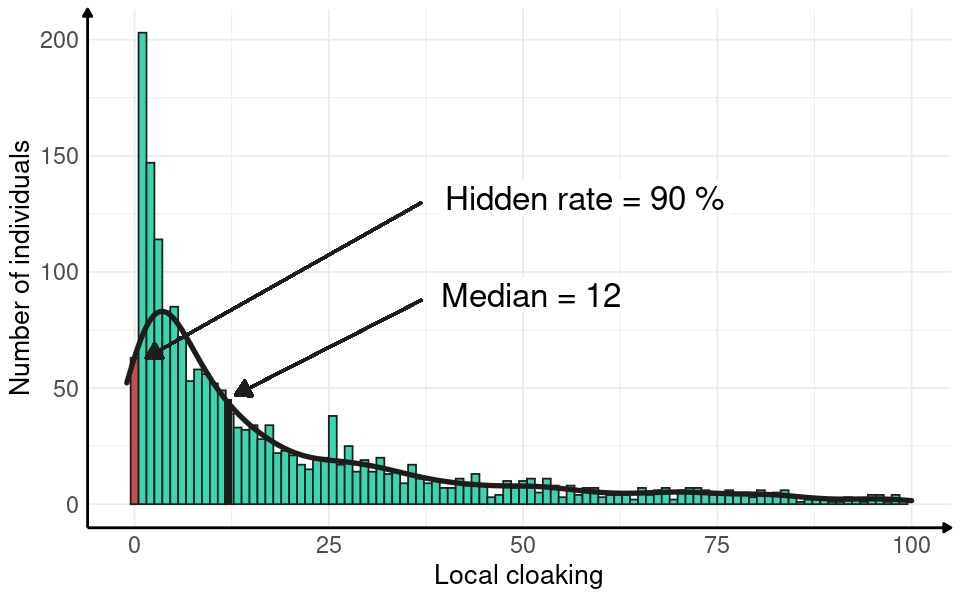

In [29]:
color_vector = c(rep("#c14f4f", 2), rep(colors["avatar", "color"], 98))
intersect_median_density <- 100


options(repr.plot.width = 8, repr.plot.height = 5)
plot = ggplot(df_local_cloaking, aes(hit_counts.1)) + 
    # add histogram
    geom_histogram(bins = 100, fill = color_vector, color = "#1D1D1B") + 
    #  add density
    geom_density(aes(y = ..count..), lwd = 1.5, color = "#1D1D1B") + 
    # add median
    geom_segment(aes(x = median(hit_counts.1), y = 0, xend = median(hit_counts.1), yend = 45), 
                 color = "#1D1D1B", size = 1.5) +
    # theme, axis, leged
    theme_minimal() + 
    xlab("Local cloaking") + 
    ylab("Number of individuals") + 
    theme(axis.title = element_text(size = 16, family = "sans"), 
          axis.text = element_text(size = 14, family = "sans"), 
          axis.line = element_line(colour = "black", size = 0.8, 
                                   linetype = "solid", arrow = arrow(type = "closed", length = unit(5, "pt")))) +
    # add arrow and text 
    ## segment median 
    geom_segment(aes(x = median(hit_counts.1),
                     y = 0, xend = median(hit_counts.1),
                     yend = 45), 
                 color = '#1D1D1B', size = 2) +
    ## arrow median
    geom_segment(aes(x = median(hit_counts.1) + 25,
                     y = intersect_median_density -12, 
                     xend = median(hit_counts.1)+1,
                     yend = 45+2), 
                 color = '#1D1D1B', size = 0.8, 
                 arrow = arrow(type='closed', length = unit(10,'pt'))) +
    ## text median
    geom_label(aes(x =  median(hit_counts.1) + 39., 
                   y =  intersect_median_density -10,
                   label =paste0("Median = ", median(hit_counts.1))), 
               size = 7, 
               family = "sans", 
               label.size = NA) + 
    ## arrow hidden rate
    geom_segment(aes(x = median(hit_counts.1) + 25, 
                     y = intersect_median_density + 30, 
                     xend = 1.5, yend = sum(df_local_cloaking[,1] == 0) ), 
                 color = '#1D1D1B', size = 0.8, 
                 arrow = arrow(type='closed', 
                               length = unit(10,'pt'))) +
    ## text hidden rate
    geom_label(aes(x =  median(hit_counts.1) + 46, 
                   y = intersect_median_density + 32,
                   label = paste0("Hidden rate = ", round(metrics$hidden_rate, 0), " %")), 
               size = 7, 
               family = "sans", 
               label.size = NA) +
        xlim(c(-1, 100)) 


plot 

ggsave(file="../../figure/aids_local_cloaking.tiff", plot=plot, width=8, height=5, dpi = 320)

###  Zero cloaking over 25 avatarizations

Here, we performed 25 different avatarizations with the same parameters **(`k = 20, nf = 5`)**.  
Then, we looked at the number of time, each individual generates an avatar with a local cloaking of 0.

We printed the distribution and the number of individuals according to the number of zero local cloaking.

In [29]:
avatar_tot <- read.csv('../../datasets/AIDS/aids_avatarized_25time_k20_nf_5.csv')
avatar_tot[categorical] <- lapply(avatar_tot[categorical], factor)
data[categorical] <- lapply(data[categorical], factor)
pr <- py$Projection()
coord_original <- pr$fit_transform(data[,-ncol(data)], nf = 5L)[[1]]

In [30]:
# Computation time: about 2 minutes
defaultW <- getOption("warn")
options(warn = -1)
df_local_cloaking_k2 <- data.frame(row.names = 1:nrow(data))
for (k in unique(avatar_tot$iter)){
    avatar <- avatar_tot[avatar_tot$iter == k,]
    avatar_imp <- complete(mice(avatar, m = 1, maxit = 50, seed = 500, printFlag = FALSE), 1)
    avatar$cd496 <- avatar_imp$cd496
    
    coord_avatar <- pr$transform(avatar[, 1:(ncol(avatar) - 1)])
    distances <- py$record_to_avatar_distance(coord_original, coord_avatar)
    
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k2[paste0("local_cloaking_", k, "_", 20)] <- local_cloaking$hit_counts[, 1]
}   
options(warn = defaultW)

In [31]:
df_local_cloaking_k2_LC0 <- as.data.frame(table(rowSums(df_local_cloaking_k2 == 0)))
df_local_cloaking_k2_LC0$Var1 = as.numeric(df_local_cloaking_k2_LC0$Var1) -1 


# count high values
high = sum(df_local_cloaking_k2_LC0[df_local_cloaking_k2_LC0["Var1"]>= 5,c("Var1")])
           
           
df_local_cloaking = df_local_cloaking_k2_LC0[df_local_cloaking_k2_LC0["Var1"]< 5,]
df_local_cloaking_k2_LC0 = rbind(df_local_cloaking, c("≥ 5", high))

df_local_cloaking_k2_LC0$Freq = as.numeric(df_local_cloaking_k2_LC0$Freq)

df_local_cloaking_k2_LC0["Freq2"] <- paste0(formatC(df_local_cloaking_k2_LC0$Freq/sum(df_local_cloaking_k2_LC0$Freq)*100, format = "f", digits = 1), "%")

df_local_cloaking_k2_LC0$Var1 = factor(df_local_cloaking_k2_LC0$Var1, level = c('0','1', '2', '3','4', '≥ 5'))
levels(df_local_cloaking_k2_LC0$Var1)

df_local_cloaking_k2_LC0

[1] "0"   "1"   "2"   "3"   "4"   "≥ 5"

Var1,Freq,Freq2
<fct>,<dbl>,<chr>
0,1216,56.7%
1,593,27.7%
2,224,10.4%
3,67,3.1%
4,26,1.2%
≥ 5,18,0.8%


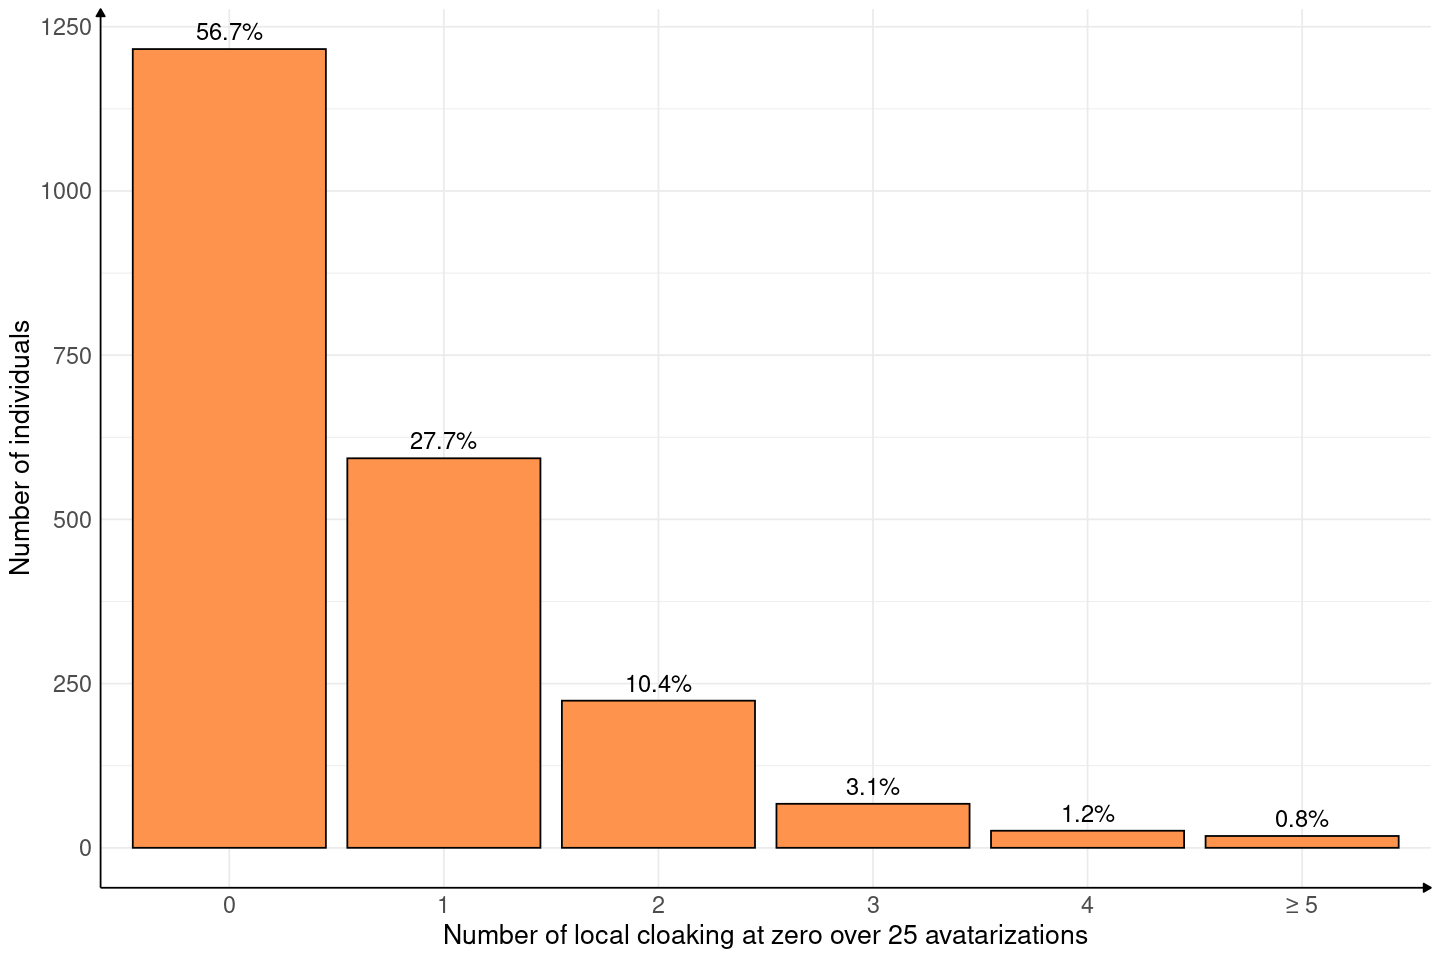

In [35]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot = ggplot(df_local_cloaking_k2_LC0, aes(x = as.factor(Var1), y = Freq)) + 
    geom_bar(stat = "identity", fill = colors["original", "color"], colour = "black", show.legend = FALSE) + 
    geom_text(aes(label = Freq2), stat = "identity", vjust = -0.5, size = 5) + 
    ylab("Number of individuals") + 
    xlab("Number of local cloaking at zero over 25 avatarizations") + 
    theme_minimal() + 
    theme(axis.title = element_text(size = 16, family = "sans"), 
          axis.text = element_text(size = 14, family = "sans"), 
          axis.line = element_line(colour = "black", size = 0.5, 
                                   linetype = "solid", 
                                   arrow = arrow(type = "closed", 
                                                 length = unit(5, "pt"))))

plot
ggsave(file="../../figure/aids_zeroCloaking_percentage.svg", plot=plot, width=8, height=5, dpi = 320)

## Supplemental analysis: P(X=0)

We also computed the probability of getting a local cloaking at  `c(0, 1, 2, 3, 4, 5 and more)`.

In [78]:
df_localCloaking_plot <- df_local_cloaking_k2
df_localCloaking_plot[df_localCloaking_plot >= 5] <- 5
df_localCloaking_plot["names"] <- as.numeric(rownames(df_localCloaking_plot))

In [79]:
freq_local_cloaking <- as.data.frame(table(melt(df_localCloaking_plot, id.vars = "names")$value))
freq_local_cloaking["Freq"] <- formatC(freq_local_cloaking[,"Freq"]/sum(freq_local_cloaking[,"Freq"])*100, format = "f", digits = 2)
freq_local_cloaking["Var1"] <- as.character(freq_local_cloaking[,"Var1"])
freq_local_cloaking[freq_local_cloaking["Var1"] == "5", "Var1"] <- ">= 5" # \U2265
colnames(freq_local_cloaking) <- c("Local cloaking", "Probability (%)")
freq_local_cloaking

Local cloaking,Probability (%)
<chr>,<chr>
0,2.65
1,9.88
2,6.82
3,5.36
4,4.45
>= 5,70.84


## Supplemental analysis: P(X2 = x | X1 = y) 

We looked at the conditionnal probability of getting a local cloaking of 0, 1, 2, 3, 4, or morethan 5 ; knowing that we get 0 at a previous local cloaking.

In [80]:
df_loc_6 <- df_local_cloaking_k2
df_loc_6[df_loc_6 >= 5] <- ">=5"
for (i in 1:ncol(df_loc_6)) {
    df_loc_6[,i] <- factor(df_loc_6[,i], levels = c(as.character(0:4), ">=5"))
}

In [81]:
table_recap <- data.frame()
for (i in 1:24) {
    if (length(table_recap) == 0) {
        table_recap <- table(df_loc_6[,i], df_loc_6[,i+1])
    } else {
        table_recap <- table_recap + table(df_loc_6[,i], df_loc_6[,i+1])
    }
}
table_recap <- as.matrix(round(table_recap/rowSums(table_recap), 3))
row.names(table_recap) <- paste0(c(as.character(0:4), "\U2265 5"), "  ")
colnames(table_recap) <- paste0(c(as.character(0:4), "\U2265 5"), "\n")

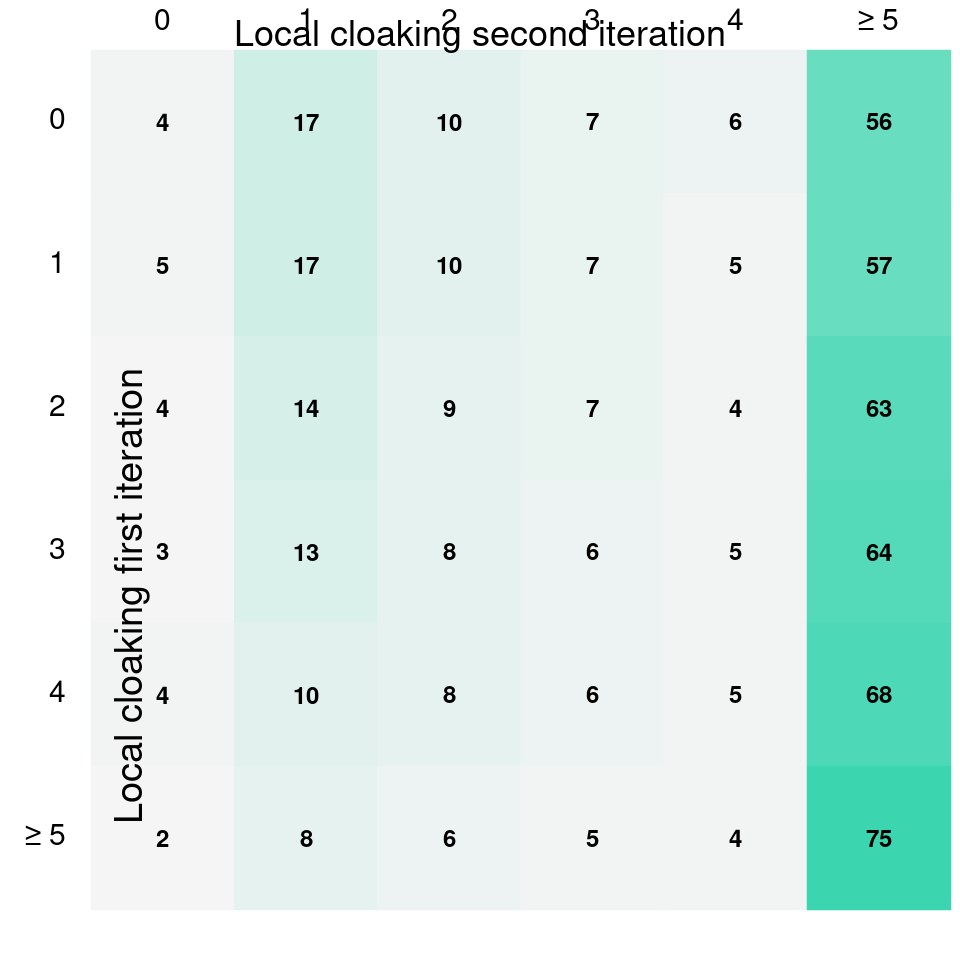

In [84]:
options(repr.plot.width = 8, repr.plot.height = 8)
save = FALSE

if (save) {svglite("../../figure/aids_Probabilities.svg", width = 8, height = 8)}
    
corrplot(table_recap, method = 'color', is.corr = FALSE, addCoef.col = 'black',
                addCoefasPercent = TRUE, number.cex = 1.2, cl.pos = 'n', 
                tl.col = 'black', tl.cex = 1.5, tl.srt = 0,
         col = colorRampPalette(c('#F5F5F5',
                                  colors["avatar", "color"]))(50)) 
mtext(text = "Local cloaking first iteration", side = 2, line = -2, las = 0, cex = 1.9, adj = 0.27) 
mtext(text = "Local cloaking second iteration", side = 3, line = 2, las = 0, cex = 1.8)

if (save) {dev.off()} 

In [51]:
getwd()

[1] "/home/user/Documents/projets/Paper/avatar_paper/notebooks/final_figure"